# A comparison of CoMIGHT against KSG and Linear Regression Based Estimates of Conditional Independence

CoMIGHT is a fully non-parametric method for i) estimating CMI and ii) providing a pvalue indicating the statistical significance of the estimated CMI compared to the null hypothesis where the CMI is 0 (for a given dimensionality and sample size using permutation principles).

Another nonparametric method for CMI is the kNN based KSG estimator, which also can be used along a permutation test to obtain a pvalue.

Finally, a parametric method for CMI is the linear regression method, which computes partial correlation among variables under the assumption that the data arises from Gaussian distributions.

In [35]:
import math
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.special import expit
from sklearn.datasets import (
    make_blobs,
    make_classification,
    make_sparse_spd_matrix,
    make_spd_matrix,
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sktree import HonestForestClassifier, RandomForestClassifier, RandomForestRegressor
from sktree.datasets.multiview import make_gaussian_mixture, make_joint_factor_model
from sktree.stats import (
    FeatureImportanceForestClassifier,
    FeatureImportanceForestRegressor,
    PermutationForestRegressor,
    PermutationTest,
)
from sktree.tree import DecisionTreeClassifier, MultiViewDecisionTreeClassifier

seed = 12345
rng = np.random.default_rng(seed)

In [36]:
import warnings

warnings.filterwarnings("ignore")

# Define Dataset Generators

1. Confounder: Y <- X1 -> X2
2. Collider: X1 -> Y <- X2
3. Independence: X1 -> Y  X2 (here we use `make_classification` from sklearn and add random noise)
4. Mediator: X1 -> X2 -> Y
5. Direct & Indirect Effects: X1 -> X2 -> Y; X1 -> Y

In [2]:
def make_confounder(n_samples, n_features, noise_dims, class_probs, seed):
    rng = np.random.default_rng(seed)

    fixed_center = rng.standard_normal(size=(n_features,))
    centers = [fixed_center, fixed_center]

    covariances = [
        make_spd_matrix(n_dim=n_features, random_state=seed),
        make_spd_matrix(n_dim=n_features, random_state=seed + 123),
    ]

    Xs, y = make_gaussian_mixture(
        centers,
        covariances,
        n_samples=n_samples,
        noise=1.0,
        noise_dims=noise_dims,
        shuffle=True,
        class_probs=class_probs,
        random_state=seed + idx,
    )

    signal_X = np.hstack((Xs[1], Xs[0]))

    return signal_X, y

In [3]:
def make_collider(n_samples, n_features, noise_dims, seed):
    signal_X_1, y1 = make_classification(
        n_samples=n_samples,
        n_features=n_features + noise_dims,
        n_informative=n_features,
        n_redundant=10,
        n_repeated=0,
        n_classes=2,
        class_sep=1.0,
        flip_y=0.02,
        shuffle=False,
        random_state=seed,
    )
    signal_X_2, y2 = make_classification(
        n_samples=n_samples,
        n_features=n_features + noise_dims,
        n_informative=n_features,
        n_redundant=10,
        n_repeated=0,
        n_classes=2,
        class_sep=0.75,
        flip_y=0.02,
        shuffle=False,
        random_state=seed + 1,
    )
    signal_X = np.hstack((signal_X_1, signal_X_2))
    y = y1.copy()

    keep_inds = np.argwhere(y1 == y2)
    y = y[keep_inds, ...]
    y2 = y2[keep_inds, ...].squeeze()
    signal_X = signal_X[keep_inds, ...].squeeze()

    np.testing.assert_array_equal(y.squeeze(), y2)
    return signal_X, y2

In [4]:
def make_mediator(n_samples, n_features, noise_dims, n_views, joint_rank, seed):
    Xs, U, _ = make_joint_factor_model(
        n_views,
        n_features,
        n_samples=n_samples,
        joint_rank=joint_rank,
        noise_std=10.0,
        m=0.25,
        random_state=seed,
        return_decomp=True,
    )

    total_n_features = n_features * n_views + noise_dims

    signal_X = np.hstack(Xs)
    signal_X += rng.standard_normal(size=signal_X.shape)
    signal_X = np.hstack(
        (
            signal_X,
            rng.standard_normal(
                size=(n_samples, total_n_features - n_features * n_views)
            ),
        )
    )
    n_features_1 = signal_X.shape[1]

    y = rng.binomial(n=1, p=expit(signal_X[:, :n_features].sum(axis=1)), size=n_samples)

    # make signal view (i.e. X1) higher-dimensional
    U += rng.standard_normal(size=U.shape)  # * 2.0
    U = np.hstack(
        (
            U,
            rng.standard_normal(
                size=(signal_X.shape[0], total_n_features - joint_rank)
            ),
        )
    )

    # print(U.shape, signal_X.shape, y.shape, [x.shape for x in Xs])
    # first view is X1, which generates X2
    X = np.hstack((U, signal_X))

    return X, y

In [5]:
def make_direct_indirect_effects(n_samples, n_features, noise_dims, class_probs, seed):
    rng = np.random.default_rng(seed)

    # make joint factor model for class 0
    Xs_list = []
    classes = []
    for idx in range(2):
        fixed_center = rng.standard_normal(size=(n_features,))
        centers = [fixed_center, fixed_center]

        covariances = [
            make_spd_matrix(n_dim=n_features, random_state=seed + idx),
            make_spd_matrix(n_dim=n_features, random_state=seed + 123 + idx),
        ]

        Xs, _ = make_gaussian_mixture(
            centers,
            covariances,
            n_samples=math.ceil(n_samples // 2),
            noise=1.0,
            noise_dims=noise_dims,
            shuffle=True,
            class_probs=class_probs,
            random_state=seed + idx,
        )
        signal_X = np.hstack((Xs[1], Xs[0]))
        print(signal_X.shape)
        Xs_list.append(signal_X)
        classes.append(np.ones((n_samples // 2, 1)) * idx)

    y = np.vstack(classes)
    print([x.shape for x in Xs])
    X = np.vstack(Xs_list)

    return X, y

In [6]:
X, y = make_mediator(500, 10, 80, 2, 5, seed)

In [7]:
print(X.shape, y.shape)

(500, 200) (500,)


# Run Computation

Warning: For high n_repeats, this takes a long time.

In [63]:
# NOTE: increase this when running for full figure to 100
n_repeats = 5

In [64]:
class_probs = [0.5, 0.5]

In [65]:
n_features = 10
noise_dims = 90
n_samples = 500
max_features = 0.3
n_jobs = -1
test_size = 0.2

max_fpr = 0.1

n_features_2_list = np.linspace(800, 10_000 - 200, 10, dtype=int)
n_features_2_list = np.insert(n_features_2_list, 0, 0)
print(n_features_2_list)

In [66]:
n_estimators = 500

## Confounder Results

In [68]:
results = defaultdict(list)

for idx in range(n_repeats):
    n_features_begin = 0
    signal_X, y = make_confounder(
        n_samples=n_samples,
        n_features=n_features,
        noise_dims=noise_dims,
        class_probs=class_probs,
        seed=seed + idx,
    )
    n_features_ends = [n_features + noise_dims, None]

    for n_features_2_ in n_features_2_list:
        _X = np.hstack((signal_X, rng.standard_normal(size=(n_samples, n_features_2_))))
        X = _X.copy()
        n_features_ends[1] = X.shape[1]

        print(X.shape, y.shape)
        print(n_features_ends)

        est = FeatureImportanceForestClassifier(
            estimator=HonestForestClassifier(
                n_estimators=n_estimators,
                max_features=max_features,
                tree_estimator=MultiViewDecisionTreeClassifier(
                    feature_set_ends=n_features_ends,
                    apply_max_features_per_feature_set=True,
                ),
                random_state=seed,
                honest_fraction=0.5,
                n_jobs=n_jobs,
            ),
            random_state=seed,
            test_size=test_size,
            sample_dataset_per_tree=False,
        )

        # compute the statistic
        # also compute the pvalue when shuffling X1
        covariate_index = np.arange(0, n_features_ends[0])
        stat, pvalue = est.test(
            X, y, covariate_index=covariate_index, metric="auc", max_fpr=max_fpr
        )
        results["mvrf_pvalue_x1"].append(pvalue)
        # get the actual partial-AUC of the unpermuted dataset for the forest
        stat = est.observe_stat_
        results["mvrf_pauc"].append(stat)

        # now compute the same relevant quantities using kNN
        neigh = KNeighborsClassifier(n_neighbors=int(np.sqrt(X.shape[1])) + 1)
        # compute pvalue for kNN based job
        permest = PermutationTest(
            neigh, n_repeats=100, random_state=seed + idx + n_features_2_
        )
        pauc, pvalue = permest.test(
            X, y, covariate_index=covariate_index, metric="auc", max_fpr=max_fpr
        )

        results["knn_pauc"].append(pauc)
        results["knn_pvalue_x1"].append(pvalue)

        # also compute the relevant quantities using linear regression
        lr = LogisticRegression(random_state=seed + idx + n_features_2_)
        permest = PermutationTest(
            lr, n_repeats=100, random_state=seed + idx + n_features_2_
        )
        pauc, pvalue = permest.test(
            X, y, covariate_index=covariate_index, metric="auc", max_fpr=max_fpr
        )
        results["lr_pvalue_x1"].append(pvalue)
        results["lr_pauc"].append(pauc)

        # now compute the pvalue when shuffling X2
        covariate_index = np.arange(n_features_ends[0], n_features_ends[1])
        _, pvalue = est.test(
            X, y, covariate_index=covariate_index, metric="auc", max_fpr=max_fpr
        )
        results["mvrf_pvalue_x2"].append(pvalue)

        # now compute the same relevant quantities using kNN
        # compute pvalue for kNN based job
        permest = PermutationTest(
            neigh, n_repeats=100, random_state=seed + idx + n_features_2_
        )
        _, pvalue = permest.test(
            X, y, covariate_index=covariate_index, metric="auc", max_fpr=max_fpr
        )
        results["knn_pvalue_x2"].append(pvalue)

        # also compute the relevant quantities using linear regression
        permest = PermutationTest(
            lr, n_repeats=100, random_state=seed + idx + n_features_2_
        )
        _, pvalue = permest.test(
            X, y, covariate_index=covariate_index, metric="auc", max_fpr=max_fpr
        )
        results["lr_pvalue_x2"].append(pvalue)

        results["n_samples"].append(n_samples)
        results["n_features_2"].append(n_features_2_)
        results["noise_dims"].append(noise_dims)

(500, 200) (500,)
[100, 200]
(500, 1000) (500,)
[100, 1000]
(500, 2000) (500,)
[100, 2000]
(500, 3000) (500,)
[100, 3000]
(500, 4000) (500,)
[100, 4000]
(500, 5000) (500,)
[100, 5000]
(500, 6000) (500,)
[100, 6000]
(500, 7000) (500,)
[100, 7000]
(500, 8000) (500,)
[100, 8000]
(500, 9000) (500,)
[100, 9000]
(500, 10000) (500,)
[100, 10000]
(500, 200) (500,)
[100, 200]
(500, 1000) (500,)
[100, 1000]
(500, 2000) (500,)
[100, 2000]
(500, 3000) (500,)
[100, 3000]
(500, 4000) (500,)
[100, 4000]
(500, 5000) (500,)
[100, 5000]
(500, 6000) (500,)
[100, 6000]
(500, 7000) (500,)
[100, 7000]
(500, 8000) (500,)
[100, 8000]
(500, 9000) (500,)
[100, 9000]
(500, 10000) (500,)
[100, 10000]
(500, 200) (500,)
[100, 200]
(500, 1000) (500,)
[100, 1000]
(500, 2000) (500,)
[100, 2000]
(500, 3000) (500,)
[100, 3000]
(500, 4000) (500,)
[100, 4000]
(500, 5000) (500,)
[100, 5000]
(500, 6000) (500,)
[100, 6000]
(500, 7000) (500,)
[100, 7000]
(500, 8000) (500,)
[100, 8000]
(500, 9000) (500,)
[100, 9000]
(500, 1000

In [69]:
df = pd.DataFrame(results)

# save the results
df.to_csv("./cv_comight_mv_vs_knn_vs_lr_confounder_model.csv")

print(df.columns)
print(df.shape)

Index(['mvrf_pvalue_x1', 'mvrf_pauc', 'knn_pauc', 'knn_pvalue_x1',
       'lr_pvalue_x1', 'lr_pauc', 'mvrf_pvalue_x2', 'knn_pvalue_x2',
       'lr_pvalue_x2', 'n_samples', 'n_features_2', 'noise_dims'],
      dtype='object')
(55, 12)


## Collider Results

In [70]:
results = defaultdict(list)

for idx in range(n_repeats):
    n_features_begin = 0
    signal_X, y = make_collider(
        n_samples=n_samples,
        n_features=n_features,
        noise_dims=noise_dims,
        seed=seed + idx,
    )
    n_features_ends = [n_features + noise_dims, None]

    for n_features_2_ in n_features_2_list:
        _X = np.hstack((signal_X, rng.standard_normal(size=(n_samples, n_features_2_))))
        X = _X.copy()
        n_features_ends[1] = X.shape[1]

        print(X.shape, y.shape)
        print(n_features_ends)

        est = FeatureImportanceForestClassifier(
            estimator=HonestForestClassifier(
                n_estimators=n_estimators,
                max_features=max_features,
                tree_estimator=MultiViewDecisionTreeClassifier(
                    feature_set_ends=n_features_ends,
                    apply_max_features_per_feature_set=True,
                ),
                random_state=seed,
                honest_fraction=0.5,
                n_jobs=n_jobs,
            ),
            random_state=seed,
            test_size=test_size,
            sample_dataset_per_tree=False,
        )

        # compute the statistic
        # also compute the pvalue when shuffling X1
        covariate_index = np.arange(0, n_features_ends[0])
        stat, pvalue = est.test(
            X, y, covariate_index=covariate_index, metric="auc", max_fpr=max_fpr
        )
        results["mvrf_pvalue_x1"].append(pvalue)
        # get the actual partial-AUC of the unpermuted dataset for the forest
        stat = est.observe_stat_
        results["mvrf_pauc"].append(stat)

        # now compute the same relevant quantities using kNN
        neigh = KNeighborsClassifier(n_neighbors=int(np.sqrt(X.shape[1])) + 1)
        # compute pvalue for kNN based job
        permest = PermutationTest(
            neigh, n_repeats=100, random_state=seed + idx + n_features_2_
        )
        pauc, pvalue = permest.test(
            X, y, covariate_index=covariate_index, metric="auc", max_fpr=max_fpr
        )

        results["knn_pauc"].append(pauc)
        results["knn_pvalue_x1"].append(pvalue)

        # also compute the relevant quantities using linear regression
        lr = LogisticRegression(random_state=seed + idx + n_features_2_)
        permest = PermutationTest(
            lr, n_repeats=100, random_state=seed + idx + n_features_2_
        )
        pauc, pvalue = permest.test(
            X, y, covariate_index=covariate_index, metric="auc", max_fpr=max_fpr
        )
        results["lr_pvalue_x1"].append(pvalue)
        results["lr_pauc"].append(pauc)

        # now compute the pvalue when shuffling X2
        covariate_index = np.arange(n_features_ends[0], n_features_ends[1])
        _, pvalue = est.test(
            X, y, covariate_index=covariate_index, metric="auc", max_fpr=max_fpr
        )
        results["mvrf_pvalue_x2"].append(pvalue)

        # now compute the same relevant quantities using kNN
        # compute pvalue for kNN based job
        permest = PermutationTest(
            neigh, n_repeats=100, random_state=seed + idx + n_features_2_
        )
        _, pvalue = permest.test(
            X, y, covariate_index=covariate_index, metric="auc", max_fpr=max_fpr
        )
        results["knn_pvalue_x2"].append(pvalue)

        # also compute the relevant quantities using linear regression
        permest = PermutationTest(
            lr, n_repeats=100, random_state=seed + idx + n_features_2_
        )
        _, pvalue = permest.test(
            X, y, covariate_index=covariate_index, metric="auc", max_fpr=max_fpr
        )
        results["lr_pvalue_x2"].append(pvalue)

        results["n_samples"].append(n_samples)
        results["n_features_2"].append(n_features_2_)
        results["noise_dims"].append(noise_dims)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 489 and the array at index 1 has size 500

In [ ]:
df = pd.DataFrame(results)

# save the results
df.to_csv("./cv_comight_mv_vs_knn_vs_lr_collider_model.csv")

print(df.columns)
print(df.shape)

## Mediator Results

In [ ]:
results = defaultdict(list)

for idx in range(n_repeats):
    n_features_begin = 0
    signal_X, y = make_mediator(
        n_samples=n_samples,
        n_features=n_features,
        noise_dims=noise_dims,
        n_views=2,
        joint_rank=5,
        seed=seed + idx,
    )
    n_features_ends = [n_features + noise_dims, None]

    for n_features_2_ in n_features_2_list:
        _X = np.hstack((signal_X, rng.standard_normal(size=(n_samples, n_features_2_))))
        X = _X.copy()
        n_features_ends[1] = X.shape[1]

        print(X.shape, y.shape)
        print(n_features_ends)

        est = FeatureImportanceForestClassifier(
            estimator=HonestForestClassifier(
                n_estimators=n_estimators,
                max_features=max_features,
                tree_estimator=MultiViewDecisionTreeClassifier(
                    feature_set_ends=n_features_ends,
                    apply_max_features_per_feature_set=True,
                ),
                random_state=seed,
                honest_fraction=0.5,
                n_jobs=n_jobs,
            ),
            random_state=seed,
            test_size=test_size,
            sample_dataset_per_tree=False,
        )

        # compute the statistic
        # also compute the pvalue when shuffling X1
        covariate_index = np.arange(0, n_features_ends[0])
        stat, pvalue = est.test(
            X, y, covariate_index=covariate_index, metric="auc", max_fpr=max_fpr
        )
        results["mvrf_pvalue_x1"].append(pvalue)
        # get the actual partial-AUC of the unpermuted dataset for the forest
        stat = est.observe_stat_
        results["mvrf_pauc"].append(stat)

        # now compute the same relevant quantities using kNN
        neigh = KNeighborsClassifier(n_neighbors=int(np.sqrt(X.shape[1])) + 1)
        # compute pvalue for kNN based job
        permest = PermutationTest(
            neigh, n_repeats=100, random_state=seed + idx + n_features_2_
        )
        pauc, pvalue = permest.test(
            X, y, covariate_index=covariate_index, metric="auc", max_fpr=max_fpr
        )

        results["knn_pauc"].append(pauc)
        results["knn_pvalue_x1"].append(pvalue)

        # also compute the relevant quantities using linear regression
        lr = LogisticRegression(random_state=seed + idx + n_features_2_)
        permest = PermutationTest(
            lr, n_repeats=100, random_state=seed + idx + n_features_2_
        )
        pauc, pvalue = permest.test(
            X, y, covariate_index=covariate_index, metric="auc", max_fpr=max_fpr
        )
        results["lr_pvalue_x1"].append(pvalue)
        results["lr_pauc"].append(pauc)

        # now compute the pvalue when shuffling X2
        covariate_index = np.arange(n_features_ends[0], n_features_ends[1])
        _, pvalue = est.test(
            X, y, covariate_index=covariate_index, metric="auc", max_fpr=max_fpr
        )
        results["mvrf_pvalue_x2"].append(pvalue)

        # now compute the same relevant quantities using kNN
        # compute pvalue for kNN based job
        permest = PermutationTest(
            neigh, n_repeats=100, random_state=seed + idx + n_features_2_
        )
        _, pvalue = permest.test(
            X, y, covariate_index=covariate_index, metric="auc", max_fpr=max_fpr
        )
        results["knn_pvalue_x2"].append(pvalue)

        # also compute the relevant quantities using linear regression
        permest = PermutationTest(
            lr, n_repeats=100, random_state=seed + idx + n_features_2_
        )
        _, pvalue = permest.test(
            X, y, covariate_index=covariate_index, metric="auc", max_fpr=max_fpr
        )
        results["lr_pvalue_x2"].append(pvalue)

        results["n_samples"].append(n_samples)
        results["n_features_2"].append(n_features_2_)
        results["noise_dims"].append(noise_dims)

In [ ]:
df = pd.DataFrame(results)

# save the results
df.to_csv("./cv_comight_mv_vs_knn_vs_lr_mediator_model.csv")

print(df.columns)
print(df.shape)

## Direct/Indirect Effect Results

In [ ]:
results = defaultdict(list)

for idx in range(n_repeats):
    n_features_begin = 0
    signal_X, y = make_direct_indirect_effects(
        n_samples=n_samples,
        n_features=n_features,
        noise_dims=noise_dims,
        class_probs=class_probs,
        seed=seed + idx,
    )
    n_features_ends = [n_features + noise_dims, None]

    for n_features_2_ in n_features_2_list:
        _X = np.hstack((signal_X, rng.standard_normal(size=(n_samples, n_features_2_))))
        X = _X.copy()
        n_features_ends[1] = X.shape[1]

        print(X.shape, y.shape)
        print(n_features_ends)

        est = FeatureImportanceForestClassifier(
            estimator=HonestForestClassifier(
                n_estimators=n_estimators,
                max_features=max_features,
                tree_estimator=MultiViewDecisionTreeClassifier(
                    feature_set_ends=n_features_ends,
                    apply_max_features_per_feature_set=True,
                ),
                random_state=seed,
                honest_fraction=0.5,
                n_jobs=n_jobs,
            ),
            random_state=seed,
            test_size=test_size,
            sample_dataset_per_tree=False,
        )

        # compute the statistic
        # also compute the pvalue when shuffling X1
        covariate_index = np.arange(0, n_features_ends[0])
        stat, pvalue = est.test(
            X, y, covariate_index=covariate_index, metric="auc", max_fpr=max_fpr
        )
        results["mvrf_pvalue_x1"].append(pvalue)
        # get the actual partial-AUC of the unpermuted dataset for the forest
        stat = est.observe_stat_
        results["mvrf_pauc"].append(stat)

        # now compute the same relevant quantities using kNN
        neigh = KNeighborsClassifier(n_neighbors=int(np.sqrt(X.shape[1])) + 1)
        # compute pvalue for kNN based job
        permest = PermutationTest(
            neigh, n_repeats=100, random_state=seed + idx + n_features_2_
        )
        pauc, pvalue = permest.test(
            X, y, covariate_index=covariate_index, metric="auc", max_fpr=max_fpr
        )

        results["knn_pauc"].append(pauc)
        results["knn_pvalue_x1"].append(pvalue)

        # also compute the relevant quantities using linear regression
        lr = LogisticRegression(random_state=seed + idx + n_features_2_)
        permest = PermutationTest(
            lr, n_repeats=100, random_state=seed + idx + n_features_2_
        )
        pauc, pvalue = permest.test(
            X, y, covariate_index=covariate_index, metric="auc", max_fpr=max_fpr
        )
        results["lr_pvalue_x1"].append(pvalue)
        results["lr_pauc"].append(pauc)

        # now compute the pvalue when shuffling X2
        covariate_index = np.arange(n_features_ends[0], n_features_ends[1])
        _, pvalue = est.test(
            X, y, covariate_index=covariate_index, metric="auc", max_fpr=max_fpr
        )
        results["mvrf_pvalue_x2"].append(pvalue)

        # now compute the same relevant quantities using kNN
        # compute pvalue for kNN based job
        permest = PermutationTest(
            neigh, n_repeats=100, random_state=seed + idx + n_features_2_
        )
        _, pvalue = permest.test(
            X, y, covariate_index=covariate_index, metric="auc", max_fpr=max_fpr
        )
        results["knn_pvalue_x2"].append(pvalue)

        # also compute the relevant quantities using linear regression
        permest = PermutationTest(
            lr, n_repeats=100, random_state=seed + idx + n_features_2_
        )
        _, pvalue = permest.test(
            X, y, covariate_index=covariate_index, metric="auc", max_fpr=max_fpr
        )
        results["lr_pvalue_x2"].append(pvalue)

        results["n_samples"].append(n_samples)
        results["n_features_2"].append(n_features_2_)
        results["noise_dims"].append(noise_dims)

In [ ]:
df = pd.DataFrame(results)

# save the results
df.to_csv("./cv_comight_mv_vs_knn_vs_lr_directindirecteffects_model.csv")

print(df.columns)
print(df.shape)

## Independent View Results

In [ ]:
n_features = 20
noise_dims = 80
n_samples = 500
max_features = 0.3
n_jobs = -1
test_size = 0.2

max_fpr = 0.1

n_features_2_list = np.linspace(900, 10_000 - 100, 10, dtype=int)
n_features_2_list = np.insert(n_features_2_list, 0, 0)
print(n_features_2_list)

In [ ]:
results = defaultdict(list)

for idx in range(n_repeats):
    n_features_begin = 0
    signal_X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        noise_dims=noise_dims,
        class_probs=class_probs,
        seed=seed + idx,
    )
    n_features_ends = [n_features + noise_dims, None]

    for n_features_2_ in n_features_2_list:
        _X = np.hstack((signal_X, rng.standard_normal(size=(n_samples, n_features_2_))))
        X = _X.copy()
        n_features_ends[1] = X.shape[1]

        print(X.shape, y.shape)
        print(n_features_ends)

        est = FeatureImportanceForestClassifier(
            estimator=HonestForestClassifier(
                n_estimators=n_estimators,
                max_features=max_features,
                tree_estimator=MultiViewDecisionTreeClassifier(
                    feature_set_ends=n_features_ends,
                    apply_max_features_per_feature_set=True,
                ),
                random_state=seed,
                honest_fraction=0.5,
                n_jobs=n_jobs,
            ),
            random_state=seed,
            test_size=test_size,
            sample_dataset_per_tree=False,
        )

        # compute the statistic
        # also compute the pvalue when shuffling X1
        covariate_index = np.arange(0, n_features_ends[0])
        stat, pvalue = est.test(
            X, y, covariate_index=covariate_index, metric="auc", max_fpr=max_fpr
        )
        results["mvrf_pvalue_x1"].append(pvalue)
        # get the actual partial-AUC of the unpermuted dataset for the forest
        stat = est.observe_stat_
        results["mvrf_pauc"].append(stat)

        # now compute the same relevant quantities using kNN
        neigh = KNeighborsClassifier(n_neighbors=int(np.sqrt(X.shape[1])) + 1)
        # compute pvalue for kNN based job
        permest = PermutationTest(
            neigh, n_repeats=100, random_state=seed + idx + n_features_2_
        )
        pauc, pvalue = permest.test(
            X, y, covariate_index=covariate_index, metric="auc", max_fpr=max_fpr
        )

        results["knn_pauc"].append(pauc)
        results["knn_pvalue_x1"].append(pvalue)

        # also compute the relevant quantities using linear regression
        lr = LogisticRegression(random_state=seed + idx + n_features_2_)
        permest = PermutationTest(
            lr, n_repeats=100, random_state=seed + idx + n_features_2_
        )
        pauc, pvalue = permest.test(
            X, y, covariate_index=covariate_index, metric="auc", max_fpr=max_fpr
        )
        results["lr_pvalue_x1"].append(pvalue)
        results["lr_pauc"].append(pauc)

        # now compute the pvalue when shuffling X2
        covariate_index = np.arange(n_features_ends[0], n_features_ends[1])
        _, pvalue = est.test(
            X, y, covariate_index=covariate_index, metric="auc", max_fpr=max_fpr
        )
        results["mvrf_pvalue_x2"].append(pvalue)

        # now compute the same relevant quantities using kNN
        # compute pvalue for kNN based job
        permest = PermutationTest(
            neigh, n_repeats=100, random_state=seed + idx + n_features_2_
        )
        _, pvalue = permest.test(
            X, y, covariate_index=covariate_index, metric="auc", max_fpr=max_fpr
        )
        results["knn_pvalue_x2"].append(pvalue)

        # also compute the relevant quantities using linear regression
        permest = PermutationTest(
            lr, n_repeats=100, random_state=seed + idx + n_features_2_
        )
        _, pvalue = permest.test(
            X, y, covariate_index=covariate_index, metric="auc", max_fpr=max_fpr
        )
        results["lr_pvalue_x2"].append(pvalue)

        results["n_samples"].append(n_samples)
        results["n_features_2"].append(n_features_2_)
        results["noise_dims"].append(noise_dims)

In [ ]:
df = pd.DataFrame(results)

# save the results
df.to_csv("./cv_comight_mv_vs_knn_vs_lr_independentview_model.csv")

print(df.columns)
print(df.shape)

# Plotting the Results

In [61]:
# melt the dataframe, to make it easier to plot
df.drop(
    [
        "noise_dims",
        # "lr_pauc",
        # "knn_pauc",
        # "mvrf_pauc",
        "mvrf_pvalue_x2",
        "lr_pvalue_x2",
        "knn_pvalue_x2",
        "mvrf_pvalue_x1",
        "lr_pvalue_x1",
        "knn_pvalue_x1",
    ],
    inplace=True,
    axis=1,
)
df = pd.melt(
    df,
    id_vars=["n_features_2", "n_samples"],
    var_name="model",
    value_name="score",
)

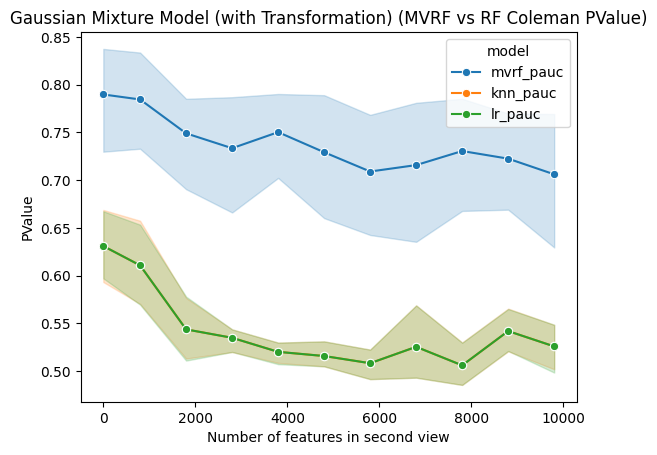

In [62]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x="n_features_2", y="score", marker="o", hue="model", ax=ax)
ax.set_ylabel("PValue")
ax.set_xlabel("Number of features in second view")
ax.set_title("Gaussian Mixture Model (with Transformation) (MVRF vs RF Coleman PValue)")
plt.show()

In [20]:
df = pd.DataFrame(np.concatenate((X, y[:, np.newaxis]), axis=1))
x_cols = np.array([f"x{idx}" for idx in range(X.shape[1])])
y_cols = np.array([f"y0"])
z_cols = x_cols[0:2]
df.columns = np.hstack((x_cols, y_cols))
print(df.columns)

Index(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
       ...
       'x191', 'x192', 'x193', 'x194', 'x195', 'x196', 'x197', 'x198', 'x199',
       'y0'],
      dtype='object', length=201)


# Compare partial-AUC performance

- compare against kNN
- compare against linear regression

# Power plots (3rd Row): Compare now the PValues when Shuffling X2

Here are the structures that are expected to reject the null because X1 \not\perp Y | X2:
1. Confounder: Y <- X1 -> X2
2. Collider: X1 -> Y <- X2
3. Independence: X1 -> Y  X2 (here we use `make_classification` from sklearn and add random noise)
4. Direct & Indirect Effects: X1 -> X2 -> Y; X1 -> Y

Here are the structures that are expected to fail to reject the null:
4. Mediator: X1 -> X2 -> Y
5. Completely independent views: X1  Y  X2

# (4th Row): Compare now the PValues when Shuffling X1

Now, we can reverse the question and compare what happens and if we correctly (fail-to) reject the null hypotheses.

Here are the structures that are expected to reject the null because X1 \not\perp Y | X2:
1. Confounder: Y <- X1 -> X2
2. Collider: X1 -> Y <- X2
3. Independence: X1 -> Y  X2 (here we use `make_classification` from sklearn and add random noise)
4. Direct & Indirect Effects: X1 -> X2 -> Y; X1 -> Y

Here are the structures that are expected to fail to reject the null:
4. Mediator: X1 -> X2 -> Y
5. Completely independent views: X1  Y  X2